# Transfer Learning with TensorFlow Part 2

Fine-tuning within transfer learning.

In [66]:
# Check gpu
!nvidia-smi

Tue Aug  9 11:32:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.57       Driver Version: 516.59       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| N/A   39C    P8    19W /  N/A |   3214MiB /  8192MiB |     13%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [49]:
### Helper Functions

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir


## Get some data

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [50]:
# Get 10% of training data of 10 classes of food 101 data.
# Download data
!wget -nc -P ../Downloads/ https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip
unzip_data('../Downloads/10_food_classes_10_percent.zip', '../Downloads')

# Check number of images and subdirectories in the dataset
walk_through_dir('../Downloads/10_food_classes_10_percent')

File ‘../Downloads/10_food_classes_10_percent.zip’ already there; not retrieving.

There are 2 directories and 0 images in '../Downloads/10_food_classes_10_percent'.
There are 10 directories and 0 images in '../Downloads/10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '../Downloads/10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '../Downloads/10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '../Downloads/10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '../Downloads/10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '../Downloads/10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '../Downloads/10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '../Downloads/10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images i

In [68]:
import tensorflow as tf
# Create training and test directory paths
train_dir = '../Downloads/10_food_classes_10_percent/train'
test_dir = '../Downloads/10_food_classes_10_percent/test'


IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            batch_size=BATCH_SIZE,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical')
                                                                            
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                            batch_size=BATCH_SIZE,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical')

IndentationError: expected an indented block after 'with' statement on line 6 (2168012501.py, line 7)

In [52]:
print(train_data_10_percent.class_names)
# see a batch of data
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']
tf.Tensor(
[[[[ 30.872448   20.872448    8.872449 ]
   [ 33.045918   23.045918   11.045918 ]
   [ 32.77551    20.77551     8.77551  ]
   ...
   [ 74.01021    36.505093   12.020442 ]
   [ 75.16834    34.168346   12.2602   ]
   [ 72.025475   31.025478   11.025477 ]]

  [[ 31.928572   21.928572    9.928572 ]
   [ 31.92857    21.928572    9.928572 ]
   [ 33.357147   21.357143    9.357143 ]
   ...
   [ 68.18877    33.71422    13.341795 ]
   [ 74.00003    36.928596   18.72452  ]
   [ 74.19381    37.122383   19.050957 ]]

  [[ 31.790817   21.790817    9.790816 ]
   [ 33.80102    23.80102    11.801021 ]
   [ 31.571426   19.571426    7.5714283]
   ...
   [ 57.744812   29.479473   16.504946 ]
   [ 57.239853   26.066378   13.295973 ]
   [ 66.36743    33.224575   21.43886  ]]

  ...

  [[176.93364   187.93364   181.93364  ]
   [178.21426   187.21426   182.21426  ]
   [18

## Creating a model with the Functional API

In [53]:
from tensorflow.keras import layers, Model, applications
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Creating a model with the Functional API
base_model = applications.EfficientNetB0(include_top=False)

# Freeze the base model (underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# Create inputs into our model
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")

# Optional param: If using ResNet50V2 you will need to normalize inputs
# Not necessary for EfficientNet(s) it has rescaling built in if coming from applications
# x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# Pass the inputs
x = base_model(inputs)
print(f'shape after passing inputs through base model: {x.shape}')

# Average pool the outputs of the base model 
# (aggregate all the most important pieces of information, reduce number of computations)
x = layers.GlobalAveragePooling2D(name="global_avg_pooling_layer")(x)
print(f'shape after GlobalAveragePooling2D: {x.shape}')

# Create the output activation layer
outputs = layers.Dense(10, activation='softmax', name="output_layer")(x)

# Combine inputs and outputs into a model
model_0 = Model(inputs=inputs, outputs=outputs, name="model_0")

# Commpile
model_0.compile(optimizer=Adam(),
                loss=CategoricalCrossentropy(),
                metrics=['accuracy'])

model_0_history = model_0.fit(train_data_10_percent,
                            epochs=5,
                            steps_per_epoch=len(train_data_10_percent),
                            validation_data=test_data,
                            validation_steps=int(0.25 * len(test_data)),
                            callbacks=create_tensorboard_callback(dir_name="../tensorflow_hub",
                                                                experiment_name="10_percent_feature_extraction")
                            )

2022-08-09 11:30:58.862175: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-09 11:30:58.862245: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 6839 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2022-08-09 11:30:58.880504: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-09 11:30:58.880551: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 6839 MB memory) -> physical PluggableDevice (device: 0, name: DM

shape after passing inputs through base model: (None, 7, 7, 1280)
shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: ../tensorflow_hub/10_percent_feature_extraction/20220809-113101
Epoch 1/5


2022-08-09 11:31:04.160317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-09 11:31:04.260276: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatDimMap' OpKernel for GPU devices compatible with node {{node model_0/efficientnetb0/block1a_se_squeeze/Mean-1-DataFormatDimMapNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU_JIT'; T in [DT_INT32, DT_INT64]
  device='GPU'; T in [DT_INT64]
  device='GPU'; T in [DT_INT32]
  device='CPU'; label='host'; T in [DT_INT64]
  device='CPU'; label='host'; T in [DT_INT32]
  device='CPU'; T in [DT_INT64]
  device='CPU'; T in [DT_INT32]

2022-08-09 11:31:04.261455: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatVecPermute' OpKernel for GPU devices compatible with node {{node model_0/efficientnetb0/block2a_dwconv_pad/Pad-1-DataFormatVecPermuteNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU

23/24 [===========================>..] - ETA: 0s - loss: 1.8810 - accuracy: 0.4239

2022-08-09 11:31:07.078874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-09 11:31:07.157033: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatDimMap' OpKernel for GPU devices compatible with node {{node model_0/efficientnetb0/block1a_se_squeeze/Mean-1-DataFormatDimMapNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU_JIT'; T in [DT_INT32, DT_INT64]
  device='GPU'; T in [DT_INT64]
  device='GPU'; T in [DT_INT32]
  device='CPU'; label='host'; T in [DT_INT64]
  device='CPU'; label='host'; T in [DT_INT32]
  device='CPU'; T in [DT_INT64]
  device='CPU'; T in [DT_INT32]

2022-08-09 11:31:07.158355: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatVecPermute' OpKernel for GPU devices compatible with node {{node model_0/efficientnetb0/block2a_dwconv_pad/Pad-1-DataFormatVecPermuteNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU

24/24 [==============================] - 7s 150ms/step - loss: 1.8700 - accuracy: 0.4307 - val_loss: 1.3004 - val_accuracy: 0.7418
Epoch 2/5
24/24 [==============================] - 3s 106ms/step - loss: 1.0775 - accuracy: 0.7840 - val_loss: 0.8315 - val_accuracy: 0.8240
Epoch 3/5
24/24 [==============================] - 3s 106ms/step - loss: 0.7881 - accuracy: 0.8253 - val_loss: 0.6576 - val_accuracy: 0.8569
Epoch 4/5
24/24 [==============================] - 3s 106ms/step - loss: 0.6272 - accuracy: 0.8600 - val_loss: 0.5782 - val_accuracy: 0.8569
Epoch 5/5
24/24 [==============================] - 3s 107ms/step - loss: 0.5369 - accuracy: 0.8867 - val_loss: 0.5313 - val_accuracy: 0.8668


In [54]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 5s 57ms/step - loss: 0.5485 - accuracy: 0.8624


[0.5485138297080994, 0.8624000549316406]

In [55]:
# Check the layers in the base model
for layers_number, layer in enumerate(base_model.layers):
    print(f'{layers_number}: {layer.name}')

0: input_2
1: rescaling_1
2: normalization_1
3: tf.math.truediv_1
4: stem_conv_pad
5: stem_conv
6: stem_bn
7: stem_activation
8: block1a_dwconv
9: block1a_bn
10: block1a_activation
11: block1a_se_squeeze
12: block1a_se_reshape
13: block1a_se_reduce
14: block1a_se_expand
15: block1a_se_excite
16: block1a_project_conv
17: block1a_project_bn
18: block2a_expand_conv
19: block2a_expand_bn
20: block2a_expand_activation
21: block2a_dwconv_pad
22: block2a_dwconv
23: block2a_bn
24: block2a_activation
25: block2a_se_squeeze
26: block2a_se_reshape
27: block2a_se_reduce
28: block2a_se_expand
29: block2a_se_excite
30: block2a_project_conv
31: block2a_project_bn
32: block2b_expand_conv
33: block2b_expand_bn
34: block2b_expand_activation
35: block2b_dwconv
36: block2b_bn
37: block2b_activation
38: block2b_se_squeeze
39: block2b_se_reshape
40: block2b_se_reduce
41: block2b_se_expand
42: block2b_se_excite
43: block2b_project_conv
44: block2b_project_bn
45: block2b_drop
46: block2b_add
47: block3a_expan

In [56]:
# print summary of the base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_1 (Rescaling)        (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_1 (Normalization  (None, None, None,   7          ['rescaling_1[0][0]']            
 )                              3)                                                   

In [57]:
# how about a summary of our whole model?
model_0.summary()

Model: "model_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


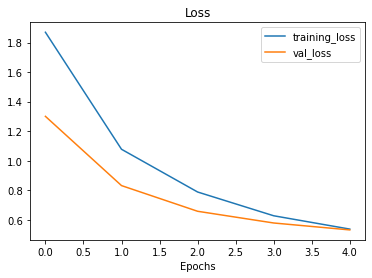

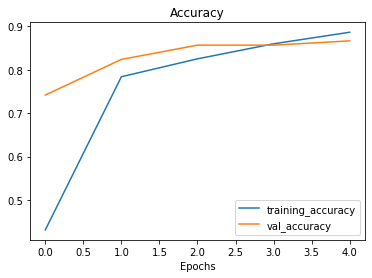

In [58]:
# Check out the models training curves
plot_loss_curves(model_0_history)

## Getting a feature vector from a trained model

Demonstrate the Global Average Pooling 2D layer:

We have tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

Then when it passes through `GlobalAveragePooling2D`, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to `GlobalAveragePooling2D`.


In [59]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor:\n {input_tensor}\n')

# Pass the random tensor through a global average pooling 2D layer
global_avg_pooled_tensor = layers.GlobalAveragePooling2D()(input_tensor)
print(f'Global average pooling 2D layer:\n {global_avg_pooled_tensor}\n')

# Check the shape of the different tensors
print(f'Shape of input tensor: {input_tensor.shape}')
print(f'Shape of global average pooled tensor: {global_avg_pooled_tensor.shape}')

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

Global average pooling 2D layer:
 [[-0.09368648 -0.45840442 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of global average pooled tensor: (1, 3)


2022-08-09 11:31:26.838395: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-09 11:31:26.838448: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 6839 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


In [60]:
# Replicate the Global Average Pooling 2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368648, -0.45840442, -0.2885598 ]], dtype=float32)>

In [61]:
# Pass the random tensor through a global max pooling 2D layer
global_max_pooled_tensor = layers.GlobalMaxPooling2D()(input_tensor)
print(f'Global max pooling 2D layer:\n {global_max_pooled_tensor}\n')
print(f'Shape of global max pooled tensor: {global_max_pooled_tensor.shape}')

Global max pooling 2D layer:
 [[0.9058464 1.1603122 1.6994323]]

Shape of global max pooled tensor: (1, 3)


## Running a series of transfer learning experiments

How does transfer learning work with 1% of the training data?

0. `model_0` - baseline model

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation
3. `model_3` - use fine-tuning transfer learning with 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning with 100% of the training data with data augmentation

**Note:** Throughout all experiments, the same test dataset will be used to evaluate our model.  This ensures consistency aross evaluation metrics.

#### Getting & preprocessing data for 1%

In [ ]:
# Download and unzip data - preprocessed from Food101
!wget -nc -P ../Downloads/ https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
# Unzip
unzip_data('../Downloads/10_food_classes_1_percent.zip', '../Downloads')

# Check number of images and subdirectories in the dataset
walk_through_dir('../Downloads/10_food_classes_1_percent')

In [63]:
# Create training and test directory paths
train_dir_1_percent = '../Downloads/10_food_classes_1_percent/train'
test_dir_1_percent = '../Downloads/10_food_classes_1_percent/test'

# Setup dataloaders
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                            batch_size=BATCH_SIZE,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical')
                                                                            
test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir_1_percent,
                                                                            batch_size=BATCH_SIZE,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical')

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


#### Adding data augmentation

To add data augmentation into a model, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

When passed as a layer to a model, data augmentation is automatically turned on during training but turned off during inference (does not augment testing data or new unseen data)

In [72]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc.

with tf.device('/cpu:0'):
    data_augmentation = Sequential([
        preprocessing.RandomFlip('horizontal'),
        preprocessing.RandomRotation(0.2),
        preprocessing.RandomZoom(0.2),
        preprocessing.RandomHeight(0.2),
        preprocessing.RandomWidth(0.2),
        # preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 but EfficientNet's have rescaling built-in
    ], name="data_augmentation")

#### Visualize the data augmentation layer
This is because of a recent update to how augmentation layers work in TensorFlow 2.8.

A fix should be on the way from the TensorFlow team but for now, one way to fix it is to make sure the parameter training=True is passed to a data augmentation model.

This is because data augmentation is only intended to work during training and not testing.

Code before
This code appears at 5:46 in the next video.

augmented_img = data_augmentation(img)

Doing this would result in images sometimes not being augmented (changed).

Code after the fix
augmented_img = data_augmentation(img, training=True)

(-0.5, 575.5, 412.5, -0.5)

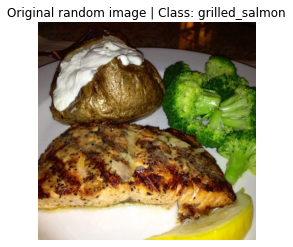

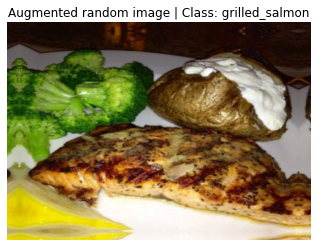

In [94]:
# View a random image and compare it to its augmented version

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = '../Downloads/10_food_classes_1_percent/train/' + target_class
# print(os.listdir())
random_image = random.choice(os.listdir(target_dir))
random_image_path = os.path.join(target_dir, random_image)

# Read in random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f'Original random image | Class: {target_class}')
plt.axis(False)

# Plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0), training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f'Augmented random image | Class: {target_class}')
plt.axis(False)



### Model 1
#### Feature extraction transfer learning on 1% of the data with augmentation

In [111]:
# Setup input shape and base model, freeze base model layers

input_shape = (IMG_SIZE + (3,))
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add data augmentation Sequential model as a layer
x = data_augmentation(inputs) # Augment our training images (augmentation doesn't occur on test data)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False) 
# Pass augmented images through base_model but keep it in inference mode, 
# this insures batchnorm layers don't update

# Pool output features of the base_model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation='softmax', name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = tf.keras.Model(inputs, outputs, name="model_1")

# Compile the model
model_1.compile(loss=CategoricalCrossentropy(),
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_model_1 = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data, 
                                validation_steps=int(0.25 * len(test_data)),
                                # Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name="../tensorflow_hub",
                                                                experiment_name="1_percent_data_aug")]
                                )


2022-08-09 12:55:04.857044: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-09 12:55:04.857123: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 6839 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2022-08-09 12:55:04.880831: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-09 12:55:04.880905: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 6839 MB memory) -> physical PluggableDevice (device: 0, name: DM

Saving TensorBoard log files to: ../tensorflow_hub/1_percent_data_aug/20220809-125507
Epoch 1/5


2022-08-09 12:55:11.061302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-09 12:55:11.180294: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatDimMap' OpKernel for GPU devices compatible with node {{node model_1/efficientnetb0/block1a_se_squeeze/Mean-1-DataFormatDimMapNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU_JIT'; T in [DT_INT32, DT_INT64]
  device='GPU'; T in [DT_INT64]
  device='GPU'; T in [DT_INT32]
  device='CPU'; label='host'; T in [DT_INT64]
  device='CPU'; label='host'; T in [DT_INT32]
  device='CPU'; T in [DT_INT64]
  device='CPU'; T in [DT_INT32]

2022-08-09 12:55:11.181279: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatVecPermute' OpKernel for GPU devices compatible with node {{node model_1/efficientnetb0/block2a_dwconv_pad/Pad-1-DataFormatVecPermuteNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU

3/3 [==============================] - ETA: 0s - loss: 2.4940 - accuracy: 0.0714

2022-08-09 12:55:12.774100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-09 12:55:12.867596: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatDimMap' OpKernel for GPU devices compatible with node {{node model_1/efficientnetb0/block1a_se_squeeze/Mean-1-DataFormatDimMapNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU_JIT'; T in [DT_INT32, DT_INT64]
  device='GPU'; T in [DT_INT64]
  device='GPU'; T in [DT_INT32]
  device='CPU'; label='host'; T in [DT_INT64]
  device='CPU'; label='host'; T in [DT_INT32]
  device='CPU'; T in [DT_INT64]
  device='CPU'; T in [DT_INT32]

2022-08-09 12:55:12.868576: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatVecPermute' OpKernel for GPU devices compatible with node {{node model_1/efficientnetb0/block2a_dwconv_pad/Pad-1-DataFormatVecPermuteNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU

3/3 [==============================] - 7s 1s/step - loss: 2.4940 - accuracy: 0.0714 - val_loss: 2.2427 - val_accuracy: 0.2039
Epoch 2/5
3/3 [==============================] - 1s 662ms/step - loss: 2.1940 - accuracy: 0.2143 - val_loss: 2.1189 - val_accuracy: 0.2747
Epoch 3/5
3/3 [==============================] - 1s 652ms/step - loss: 1.9825 - accuracy: 0.3143 - val_loss: 2.0073 - val_accuracy: 0.3536
Epoch 4/5
3/3 [==============================] - 1s 662ms/step - loss: 1.8463 - accuracy: 0.3857 - val_loss: 1.9146 - val_accuracy: 0.4013
Epoch 5/5
3/3 [==============================] - 1s 671ms/step - loss: 1.6566 - accuracy: 0.5714 - val_loss: 1.8050 - val_accuracy: 0.4737


#### Evaluate and check loss curves

In [102]:
# Check out the model's summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [106]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data, steps=len(test_data))
results_1_percent_data_aug

79/79 [==============================] - 5s 60ms/step - loss: 1.7243 - accuracy: 0.5272


[1.7242941856384277, 0.5272000432014465]

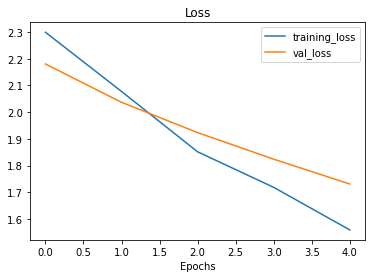

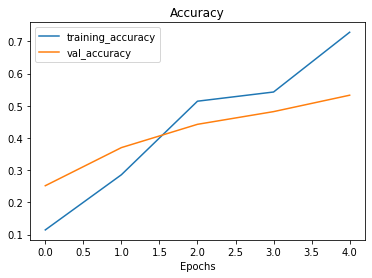

In [110]:
plot_loss_curves(history_model_1)

### Model 2
#### Feature extraction transfer learning on 10% of the data with augmentation

In [115]:
# Same as model 1 but with 10% of data
input_shape = (IMG_SIZE + (3,))
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add data augmentation Sequential model as a layer
x = data_augmentation(inputs) # Augment our training images (augmentation doesn't occur on test data)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False) 
# Pass augmented images through base_model but keep it in inference mode, 
# this insures batchnorm layers don't update

# Pool output features of the base_model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation='softmax', name="output_layer")(x)


# Make a model using the inputs and outputs
model_2 = tf.keras.Model(inputs, outputs, name="model_2")

# Compile the model
model_2.compile(loss=CategoricalCrossentropy(),
                optimizer=Adam(),
                metrics=['accuracy'])

2022-08-09 13:45:02.628484: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-09 13:45:02.628553: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 6839 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2022-08-09 13:45:02.645135: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-09 13:45:02.645189: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 6839 MB memory) -> physical PluggableDevice (device: 0, name: DM

In [114]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

#### ModelCheckpoint callback

**Model Checkpointing:** Save your model as it trains so you can stop training if needed and come back to continue where you left off.  Helpful if training takes a long time and can't be done in one sitting.

`tf.keras.callbacks.ModelCheckpoint`

In [116]:
# Set checkpoint path
checkpoint_path = "../checkpoints/10_percent_model_checkpoint_weights/checpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                                save_weights_only=True,
                                                                save_best_only=False,
                                                                save_freq="epoch", #default is save every epoch,
                                                                verbose=1
)

#### Fit model 2 passing in the ModelCheckpoint callback1

In [117]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
# Fit the model
history_model_2 = model_2.fit(train_data_10_percent,
                                epochs=initial_epochs,
                                steps_per_epoch=len(train_data_10_percent),
                                validation_data=test_data, 
                                validation_steps=int(0.25 * len(test_data)),
                                # Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name="../tensorflow_hub",
                                                                experiment_name="10_percent_data_aug"), 
                                            model_checkpoint_callback
                                    ]
                                )

Saving TensorBoard log files to: ../tensorflow_hub/10_percent_data_aug/20220809-140109
Epoch 1/5


2022-08-09 14:01:13.206127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-09 14:01:13.325783: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatDimMap' OpKernel for GPU devices compatible with node {{node model_2/efficientnetb0/block1a_se_squeeze/Mean-1-DataFormatDimMapNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU_JIT'; T in [DT_INT32, DT_INT64]
  device='GPU'; T in [DT_INT64]
  device='GPU'; T in [DT_INT32]
  device='CPU'; label='host'; T in [DT_INT64]
  device='CPU'; label='host'; T in [DT_INT32]
  device='CPU'; T in [DT_INT64]
  device='CPU'; T in [DT_INT32]

2022-08-09 14:01:13.326793: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatVecPermute' OpKernel for GPU devices compatible with node {{node model_2/efficientnetb0/block2a_dwconv_pad/Pad-1-DataFormatVecPermuteNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU

24/24 [==============================] - ETA: 0s - loss: 1.9770 - accuracy: 0.3547

2022-08-09 14:01:18.150832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-09 14:01:18.227737: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatDimMap' OpKernel for GPU devices compatible with node {{node model_2/efficientnetb0/block1a_se_squeeze/Mean-1-DataFormatDimMapNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU_JIT'; T in [DT_INT32, DT_INT64]
  device='GPU'; T in [DT_INT64]
  device='GPU'; T in [DT_INT32]
  device='CPU'; label='host'; T in [DT_INT64]
  device='CPU'; label='host'; T in [DT_INT32]
  device='CPU'; T in [DT_INT64]
  device='CPU'; T in [DT_INT32]

2022-08-09 14:01:18.229924: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatVecPermute' OpKernel for GPU devices compatible with node {{node model_2/efficientnetb0/block2a_dwconv_pad/Pad-1-DataFormatVecPermuteNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU


Epoch 1: saving model to ../checkpoints/10_percent_model_checkpoint_weights/checpoint.ckpt
24/24 [==============================] - 10s 255ms/step - loss: 1.9770 - accuracy: 0.3547 - val_loss: 1.4197 - val_accuracy: 0.7138
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2907 - accuracy: 0.7173
Epoch 2: saving model to ../checkpoints/10_percent_model_checkpoint_weights/checpoint.ckpt
24/24 [==============================] - 5s 208ms/step - loss: 1.2907 - accuracy: 0.7173 - val_loss: 0.9656 - val_accuracy: 0.8240
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0136 - accuracy: 0.7467
Epoch 3: saving model to ../checkpoints/10_percent_model_checkpoint_weights/checpoint.ckpt
24/24 [==============================] - 5s 209ms/step - loss: 1.0136 - accuracy: 0.7467 - val_loss: 0.7708 - val_accuracy: 0.8388
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.8327 - accuracy: 0.7920
Epoch 4: saving model to ../checkpoints/10_percent_mo

In [118]:
# Model 0 results
results_model_0 = model_0.evaluate(test_data)


2022-08-09 14:05:00.814082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-09 14:05:00.909150: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatDimMap' OpKernel for GPU devices compatible with node {{node model_0/efficientnetb0/block1a_se_squeeze/Mean-1-DataFormatDimMapNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU_JIT'; T in [DT_INT32, DT_INT64]
  device='GPU'; T in [DT_INT64]
  device='GPU'; T in [DT_INT32]
  device='CPU'; label='host'; T in [DT_INT64]
  device='CPU'; label='host'; T in [DT_INT32]
  device='CPU'; T in [DT_INT64]
  device='CPU'; T in [DT_INT32]

2022-08-09 14:05:00.911063: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatVecPermute' OpKernel for GPU devices compatible with node {{node model_0/efficientnetb0/block2a_dwconv_pad/Pad-1-DataFormatVecPermuteNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU

 2/79 [..............................] - ETA: 5s - loss: 0.6637 - accuracy: 0.8438 

2022-08-09 14:05:01.230346: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-09 14:05:01.230429: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 6839 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2022-08-09 14:05:01.231035: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-09 14:05:01.231077: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 6839 MB memory) -> physical PluggableDevice (device: 0, name: DM

79/79 [==============================] - 5s 60ms/step - loss: 0.5485 - accuracy: 0.8624


In [119]:
# Check 10 percent results
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 5s 61ms/step - loss: 0.6321 - accuracy: 0.8460


[0.6321014761924744, 0.8460000157356262]

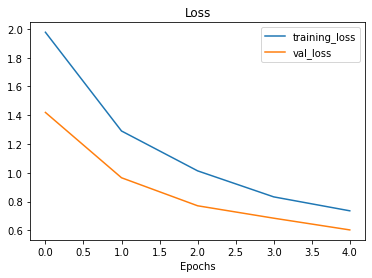

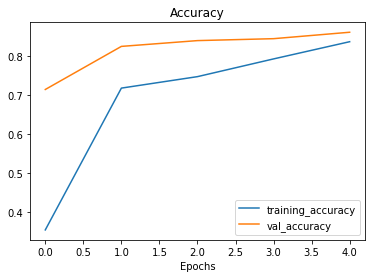

In [120]:
# Plot model loss curves
plot_loss_curves(history_model_2)

#### Load in checkpointed weights

Returns a model to a specific checkpoint

In [121]:
# Load checkpoint
model_2.load_weights(checkpoint_path)

# Evaluate loaded weights model
results_loaded_weights = model_2.evaluate(test_data)



79/79 [==============================] - 5s 59ms/step - loss: 0.6321 - accuracy: 0.8460


#### Comparing loaded weights

If the results from our previously evaluated model_2 match the loaded weights, everything has worked.
However, to check equality, the comparison has to be approximate.

Use `np.isclose()` to compare the results.

<u>**Parameters:**</u>

    a, b (array_like):

Input arrays to compare.

    rtol (float):

The relative tolerance parameter (see Notes).

    atol (float):

The absolute tolerance parameter (see Notes).

    equal_nan (bool):

Whether to compare NaN’s as equal. If True, NaN’s in a will be considered equal to NaN’s in b in the output array.

<u>**Returns:**</u>

    y (array_like):

Returns a boolean array of where a and b are equal within the given tolerance. If both a and b are scalars, returns a single boolean value.

In [125]:
import numpy as np
comparison = np.isclose(results_10_percent_data_aug, results_loaded_weights, atol=0.0001)
print(comparison)

# Actual difference 
print(np.array(results_10_percent_data_aug)-np.array(results_loaded_weights))

[ True  True]
[-1.1920929e-07  0.0000000e+00]
